## EXERCISE

Using an email spam dataset ([ENRON-SPAM](http://www2.aueb.gr/users/ion/data/enron-spam/)), we would like to test the performance of our best trained model for SMS.

In [25]:
# import libarries for reading data, exploring and plotting
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# library for train test split
from sklearn.model_selection import train_test_split

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D,GlobalAveragePooling2D,  Flatten, Dense, Dropout, LSTM, SpatialDropout1D, Bidirectional

from datetime import datetime

import tensorboard


Get both Datasets

In [26]:
emails = pd.read_csv("data/spam_ham_dataset.csv", sep =',')
messages = pd.read_csv("data/SMSSpamCollection.csv", sep ='\t',names=["label", "message"])

In [27]:
emails = emails[['label','text']]

ham_emails = emails[emails.label =='ham']
spam_emails = emails[emails.label=='spam']

ham_email_text = " ".join(ham_emails.text.to_numpy().tolist())
spam_email_text = " ".join(spam_emails.text.to_numpy().tolist())

ham_email_text[:300]

# get all the ham and spam emails
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

# For ham and spam messages, create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())


In [28]:
emails.groupby('label').describe().T

label                                                      ham           spam
text count                                                3672           1499
     unique                                               3531           1462
     top     Subject: calpine daily gas nomination\r\n>\r\n...  Subject: \r\n
     freq                                                   20             16

In [29]:
messages.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

Text(0.5, 1.0, 'Distribution of ham and spam email messages')

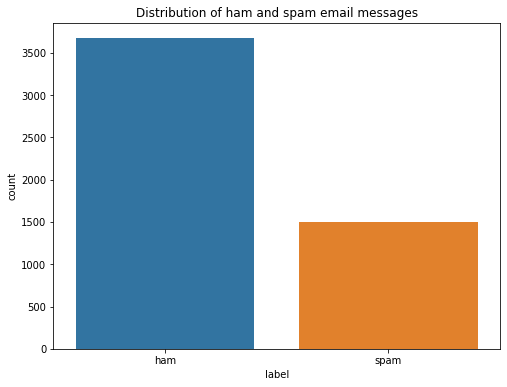

In [30]:
plt.figure(figsize=(8,6))
sns.countplot(x = emails.label)
plt.title('Distribution of ham and spam email messages')

In [31]:
# Downsample both datasets
ham_email_df = ham_emails.sample(n = len(spam_emails), random_state = 44)
spam_email_df = spam_emails

ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
#Dataframe
email_df = ham_email_df.append(spam_email_df).reset_index(drop=True)
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)

Text(0.5, 0, 'Message types')

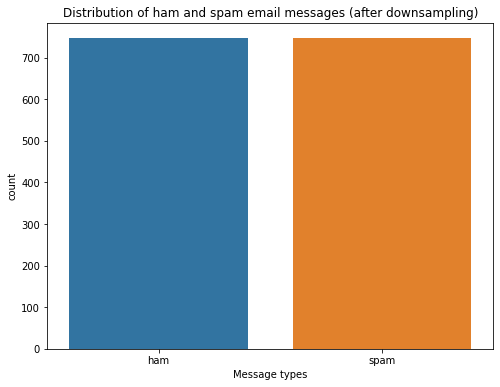

In [32]:
plt.figure(figsize=(8,6))
sns.countplot(x = msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

Text(0.5, 0, 'Message types')

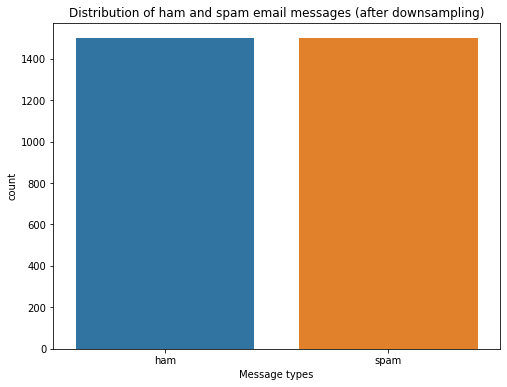

In [33]:
plt.figure(figsize=(8,6))
sns.countplot(x = email_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [34]:
# Get length column for each text
email_df['text_length'] = email_df['text'].apply(len)

#Calculate average length by label types
email_labels = email_df.groupby('label').mean()
email_labels

,text_length
label,
ham,974.549700
spam,1223.256171


In [35]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

#Calculate average length by label types
sms_labels = msg_df.groupby('label').mean()
sms_labels

,text_length
label,
ham,73.238286
spam,138.670683


Prepare the train test data

In [36]:
email_df['email_type']= email_df['label'].map({'ham': 0, 'spam': 1})
email_label = email_df['email_type'].values

msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [37]:
# Split data into train and test
train_email, remaining_email , train_labels_email, remaining_labels_email = train_test_split(email_df['text'], email_label, test_size=0.3, random_state=434)
test_email, validation_email, test_labels_email, validation_labels_email = train_test_split(remaining_email, remaining_labels_email, test_size=0.15, random_state=434)

train_msg, remaining_msg , train_labels_msg, remaining_labels_msg = train_test_split(msg_df['message'], msg_label, test_size=0.3, random_state=434)
test_msg, validation_msg, test_labels_msg, validation_labels_msg = train_test_split(remaining_msg, remaining_labels_msg, test_size=0.15, random_state=434)


In [38]:
# Defining pre-processing hyperparameters
max_len = 50 # pad_sequencs parameter, it idicates we are only going to look for 50 words in a sentence
trunc_type = "post" # direction of truncation parameter
padding_type = "post" # pad_sequences parameter
oov_tok = "<OOV>" # out of vocabulary token
vocab_size = 500

email_tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
sms_tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
email_tokenizer.fit_on_texts(train_email)
sms_tokenizer.fit_on_texts(train_msg)

In [39]:
# Get the word_index
email_word_index = email_tokenizer.word_index
sms_word_index = sms_tokenizer.word_index


tot_words_email = len(email_word_index)
tot_words_sms = len(sms_word_index)
print('There are %s unique tokens in email training data. ' % tot_words_email)
print('There are %s unique tokens in sms training data. ' % tot_words_sms)

There are 40930 unique tokens in email training data. 
There are 3836 unique tokens in sms training data. 


In [40]:
# Sequencing and padding on training and testing 
training_sequences_email = email_tokenizer.texts_to_sequences(train_email)
training_padded_email = pad_sequences (training_sequences_email, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

validation_sequences_email = email_tokenizer.texts_to_sequences(validation_email)
validation_padded_email = pad_sequences(validation_sequences_email, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

testing_sequences_email = email_tokenizer.texts_to_sequences(test_email)
testing_padded_email = pad_sequences(testing_sequences_email, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

# Sequencing and padding on training and testing 
training_sequences_sms = sms_tokenizer.texts_to_sequences(train_msg)
training_padded_sms = pad_sequences (training_sequences_sms, maxlen = max_len, 
                                 padding = padding_type, truncating = trunc_type )

validation_sequences_sms = sms_tokenizer.texts_to_sequences(validation_msg)
validation_padded_sms = pad_sequences(validation_sequences_sms, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

testing_sequences_sms = sms_tokenizer.texts_to_sequences(test_msg)
testing_padded_sms = pad_sequences(testing_sequences_sms, maxlen = max_len,
                              padding = padding_type, truncating = trunc_type)

## Train the Dense models

Email model

In [41]:
vocab_size = 500 # Number of words you want to tokenize i.e maximum number of words to keep
embedding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

#Dense sentiment model architecture
dense_email_model = Sequential()
dense_email_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
dense_email_model.add(GlobalAveragePooling1D())
dense_email_model.add(Dense(n_dense, activation='relu'))
dense_email_model.add(Dropout(drop_value))
dense_email_model.add(Dense(1, activation='sigmoid'))

dense_email_model.summary()

dense_email_model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

logdir="logs/fit/DENSE_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history_dense_email = dense_email_model.fit(training_padded_email, 
                    train_labels_email, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded_email, validation_labels_email),
                    callbacks =[early_stop, tensorboard_callback], 
                    verbose=2)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

Sms model

Evaluate dense email model

In [42]:
# Model performermance on test data is about 94.75% accuracy with validation loss of 0.11.
dense_email_model.evaluate(testing_padded_email, test_labels_email)

metrics = pd.DataFrame(history_dense_email.history)
metrics[:2]
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

24/24 [==============================] - 0s 522us/step - loss: 0.1233 - accuracy: 0.9542


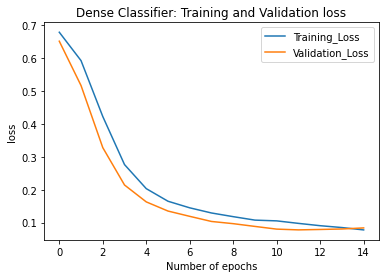

In [43]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

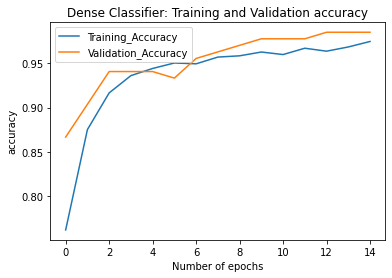

In [44]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

Evaluate dense message model

In [46]:
dense_msg_model = Sequential()
dense_msg_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
dense_msg_model.add(GlobalAveragePooling1D())
dense_msg_model.add(Dense(n_dense, activation='relu'))
dense_msg_model.add(Dropout(drop_value))
dense_msg_model.add(Dense(1, activation='sigmoid'))

dense_msg_model.summary()

dense_msg_model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

history_dense_msg = dense_msg_model.fit(training_padded_sms, 
                    train_labels_msg, 
                    epochs=num_epochs, 
                    validation_data=(validation_padded_sms, validation_labels_msg),
                    callbacks =[early_stop, tensorboard_callback], 
                    verbose=2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

In [47]:
# Model performermance on test data is about 94.75% accuracy with validation loss of 0.11.
dense_msg_model.evaluate(testing_padded_sms, test_labels_msg)

metrics = pd.DataFrame(history_dense_msg.history)
metrics[:2]
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
metrics[:2]
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Dense Classifier: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

12/12 [==============================] - 0s 637us/step - loss: 0.1172 - accuracy: 0.9475


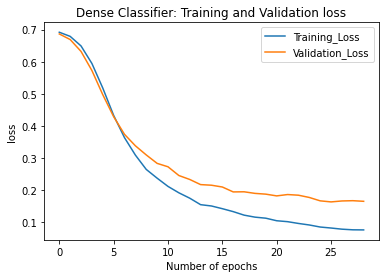

In [48]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

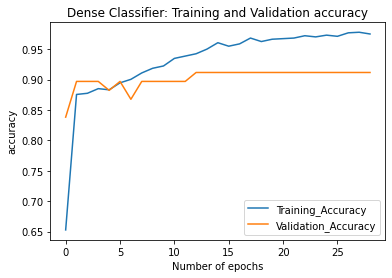

In [49]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## LSTM Layer Architecture

Email model

In [50]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20
drop_lstm = 0.2
#LSTM Spam detection architecture
lstm_email_model = Sequential()
lstm_email_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
lstm_email_model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
lstm_email_model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
lstm_email_model.add(Dense(1, activation='sigmoid'))
lstm_email_model.add(GlobalAveragePooling1D())

In [51]:
lstm_email_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [52]:
lstm_email_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm (LSTM)                 (None, 50, 20)            2960      
                                                                 
 lstm_1 (LSTM)               (None, 50, 20)            3280      
                                                                 
 dense_6 (Dense)             (None, 50, 1)             21        
                                                                 
 global_average_pooling1d_3   (None, 1)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 14,261
Trainable params: 14,261
Non-trainable params: 0
__________________________________________________

In [53]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/LSTM_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
#print(logdir)
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = lstm_email_model.fit(training_padded_email, 
                     train_labels_email, 
                     epochs=num_epochs, 
                     validation_data=(validation_padded_email, validation_labels_email),
                     callbacks =[early_stop, tensorboard_callback], 
                     verbose=2)

Epoch 1/30
66/66 - 4s - loss: 0.5587 - accuracy: 0.6830 - val_loss: 0.3128 - val_accuracy: 0.8889 - 4s/epoch - 59ms/step
Epoch 2/30
66/66 - 1s - loss: 0.2478 - accuracy: 0.9328 - val_loss: 0.2069 - val_accuracy: 0.9556 - 1s/epoch - 19ms/step
Epoch 3/30
66/66 - 1s - loss: 0.1868 - accuracy: 0.9490 - val_loss: 0.1784 - val_accuracy: 0.9481 - 1s/epoch - 19ms/step
Epoch 4/30
66/66 - 1s - loss: 0.1626 - accuracy: 0.9571 - val_loss: 0.1682 - val_accuracy: 0.9556 - 1s/epoch - 19ms/step
Epoch 5/30
66/66 - 1s - loss: 0.1452 - accuracy: 0.9643 - val_loss: 0.1647 - val_accuracy: 0.9556 - 1s/epoch - 18ms/step
Epoch 6/30
66/66 - 1s - loss: 0.1345 - accuracy: 0.9690 - val_loss: 0.1765 - val_accuracy: 0.9333 - 1s/epoch - 19ms/step
Epoch 7/30
66/66 - 1s - loss: 0.1282 - accuracy: 0.9719 - val_loss: 0.1214 - val_accuracy: 0.9556 - 1s/epoch - 19ms/step
Epoch 8/30
66/66 - 1s - loss: 0.1179 - accuracy: 0.9728 - val_loss: 0.1243 - val_accuracy: 0.9556 - 1s/epoch - 19ms/step
Epoch 9/30
66/66 - 1s - loss: 0.

In [54]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

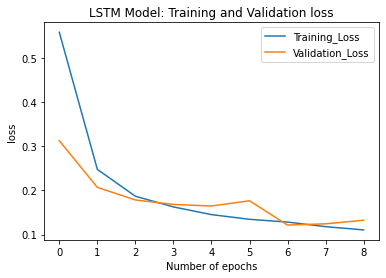

In [55]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

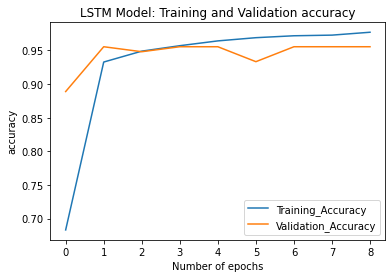

In [56]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

Sms model

In [57]:
#LSTM layer arcitecture hyperparameters
n_lstm = 20
drop_lstm = 0.2
#LSTM Spam detection architecture
lstm_msg_model = Sequential()
lstm_msg_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
lstm_msg_model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
lstm_msg_model.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
lstm_msg_model.add(Dense(1, activation='sigmoid'))
lstm_msg_model.add(GlobalAveragePooling1D())

In [58]:
lstm_msg_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [59]:
lstm_msg_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm_2 (LSTM)               (None, 50, 20)            2960      
                                                                 
 lstm_3 (LSTM)               (None, 50, 20)            3280      
                                                                 
 dense_7 (Dense)             (None, 50, 1)             21        
                                                                 
 global_average_pooling1d_4   (None, 1)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 14,261
Trainable params: 14,261
Non-trainable params: 0
__________________________________________________

In [60]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/LSTM_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
#print(logdir)
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = lstm_msg_model.fit(training_padded_sms, 
                     train_labels_msg, 
                     epochs=num_epochs, 
                     validation_data=(validation_padded_sms, validation_labels_msg),
                     callbacks =[early_stop, tensorboard_callback], 
                     verbose=2)

Epoch 1/30
33/33 - 3s - loss: 0.6629 - accuracy: 0.7541 - val_loss: 0.5701 - val_accuracy: 0.8529 - 3s/epoch - 98ms/step
Epoch 2/30
33/33 - 1s - loss: 0.3754 - accuracy: 0.9033 - val_loss: 0.3121 - val_accuracy: 0.8971 - 638ms/epoch - 19ms/step
Epoch 3/30
33/33 - 1s - loss: 0.2424 - accuracy: 0.9368 - val_loss: 0.2927 - val_accuracy: 0.8971 - 640ms/epoch - 19ms/step
Epoch 4/30
33/33 - 1s - loss: 0.2125 - accuracy: 0.9464 - val_loss: 0.3162 - val_accuracy: 0.8824 - 613ms/epoch - 19ms/step
Epoch 5/30
33/33 - 1s - loss: 0.1820 - accuracy: 0.9579 - val_loss: 0.2730 - val_accuracy: 0.8971 - 606ms/epoch - 18ms/step
Epoch 6/30
33/33 - 1s - loss: 0.1715 - accuracy: 0.9541 - val_loss: 0.2583 - val_accuracy: 0.8824 - 627ms/epoch - 19ms/step
Epoch 7/30
33/33 - 1s - loss: 0.1459 - accuracy: 0.9675 - val_loss: 0.2737 - val_accuracy: 0.8971 - 629ms/epoch - 19ms/step
Epoch 8/30
33/33 - 1s - loss: 0.1291 - accuracy: 0.9751 - val_loss: 0.2901 - val_accuracy: 0.8824 - 623ms/epoch - 19ms/step


In [61]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

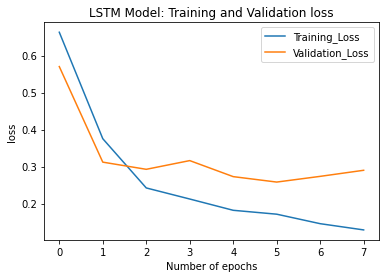

In [62]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

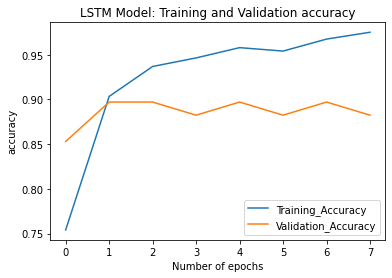

In [63]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

## Bidirectional LSTM Architecture

Email model

In [64]:
# Biderectional LSTM Spam detection architecture
Bi_email_model = Sequential()
Bi_email_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
Bi_email_model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
Bi_email_model.add(Dense(1, activation='sigmoid'))
Bi_email_model.add(GlobalAveragePooling1D())

In [65]:
Bi_email_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [66]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/BiLSTM_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
#print(logdir)

In [67]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = Bi_email_model.fit(training_padded_email, 
                     train_labels_email, 
                     epochs=num_epochs, 
                     validation_data=(validation_padded_email, validation_labels_email),
                     callbacks =[early_stop, tensorboard_callback], 
                     verbose=2)

Epoch 1/30
66/66 - 3s - loss: 0.6065 - accuracy: 0.6602 - val_loss: 0.3198 - val_accuracy: 0.9037 - 3s/epoch - 49ms/step
Epoch 2/30
66/66 - 1s - loss: 0.2515 - accuracy: 0.9214 - val_loss: 0.2141 - val_accuracy: 0.9481 - 767ms/epoch - 12ms/step
Epoch 3/30
66/66 - 1s - loss: 0.1562 - accuracy: 0.9538 - val_loss: 0.1498 - val_accuracy: 0.9481 - 776ms/epoch - 12ms/step
Epoch 4/30
66/66 - 1s - loss: 0.1147 - accuracy: 0.9633 - val_loss: 0.1126 - val_accuracy: 0.9481 - 776ms/epoch - 12ms/step
Epoch 5/30
66/66 - 1s - loss: 0.0973 - accuracy: 0.9690 - val_loss: 0.1141 - val_accuracy: 0.9407 - 775ms/epoch - 12ms/step
Epoch 6/30
66/66 - 1s - loss: 0.0833 - accuracy: 0.9704 - val_loss: 0.1051 - val_accuracy: 0.9481 - 802ms/epoch - 12ms/step
Epoch 7/30
66/66 - 1s - loss: 0.0715 - accuracy: 0.9747 - val_loss: 0.1180 - val_accuracy: 0.9556 - 831ms/epoch - 13ms/step
Epoch 8/30
66/66 - 1s - loss: 0.0634 - accuracy: 0.9786 - val_loss: 0.0602 - val_accuracy: 0.9852 - 810ms/epoch - 12ms/step
Epoch 9/30


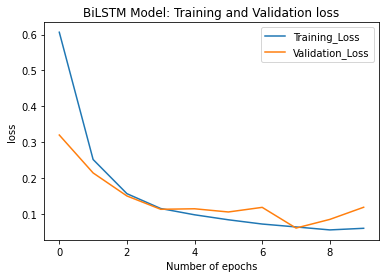

In [68]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')


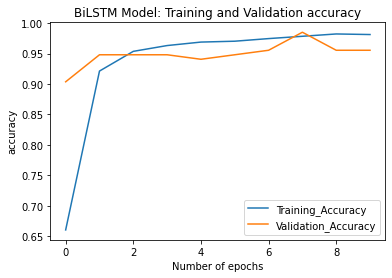

In [69]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

Sms Model

In [70]:
# Biderectional LSTM Spam detection architecture
Bi_sms_model = Sequential()
Bi_sms_model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
Bi_sms_model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
Bi_sms_model.add(Dense(1, activation='sigmoid'))
Bi_sms_model.add(GlobalAveragePooling1D())

In [71]:
Bi_sms_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [72]:
Bi_sms_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 16)            8000      
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 50, 1)             41        
                                                                 
 global_average_pooling1d_6   (None, 1)                0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 13,961
Trainable params: 13,961
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/BiLSTM_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
#print(logdir)
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = Bi_sms_model.fit(training_padded_sms, 
                     train_labels_msg, 
                     epochs=num_epochs, 
                     validation_data=(validation_padded_sms, validation_labels_msg),
                     callbacks =[early_stop, tensorboard_callback], 
                     verbose=2)

Epoch 1/30
33/33 - 3s - loss: 0.6856 - accuracy: 0.5378 - val_loss: 0.6727 - val_accuracy: 0.5000 - 3s/epoch - 91ms/step
Epoch 2/30
33/33 - 0s - loss: 0.5183 - accuracy: 0.7981 - val_loss: 0.3819 - val_accuracy: 0.8529 - 391ms/epoch - 12ms/step
Epoch 3/30
33/33 - 0s - loss: 0.2329 - accuracy: 0.9311 - val_loss: 0.2908 - val_accuracy: 0.8971 - 386ms/epoch - 12ms/step
Epoch 4/30
33/33 - 0s - loss: 0.1993 - accuracy: 0.9196 - val_loss: 0.2920 - val_accuracy: 0.8824 - 383ms/epoch - 12ms/step
Epoch 5/30
33/33 - 0s - loss: 0.1672 - accuracy: 0.9359 - val_loss: 0.2724 - val_accuracy: 0.8971 - 381ms/epoch - 12ms/step
Epoch 6/30
33/33 - 0s - loss: 0.1399 - accuracy: 0.9493 - val_loss: 0.2648 - val_accuracy: 0.8971 - 386ms/epoch - 12ms/step
Epoch 7/30
33/33 - 0s - loss: 0.1200 - accuracy: 0.9579 - val_loss: 0.2640 - val_accuracy: 0.8971 - 373ms/epoch - 11ms/step
Epoch 8/30
33/33 - 0s - loss: 0.1034 - accuracy: 0.9675 - val_loss: 0.2870 - val_accuracy: 0.8676 - 383ms/epoch - 12ms/step
Epoch 9/30


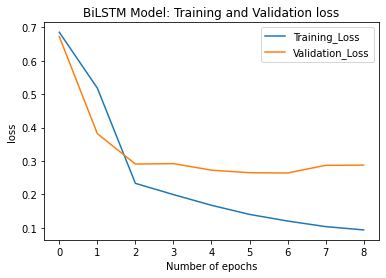

In [74]:
# Create a dataframe
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

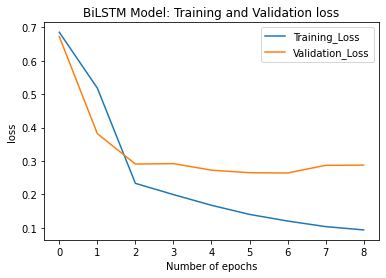

In [75]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

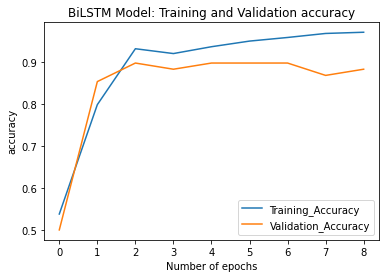

In [76]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

### Comparison

In [77]:
# Comparing three different Sms models
print(f"Dense architecture loss and accuracy for sms data: {dense_msg_model.evaluate(testing_padded_sms, test_labels_msg)} " )
print(f"LSTM architecture loss and accuracy for sms data: {lstm_msg_model.evaluate(testing_padded_sms, test_labels_msg)} " )
print(f"Bi-LSTM architecture loss and accuracy for sms data: {Bi_sms_model.evaluate(testing_padded_sms, test_labels_msg)} " )

# Comparing three different Sms models
print(f"Dense architecture loss and accuracy for email data: {dense_email_model.evaluate(testing_padded_email, test_labels_email)} " )
print(f"LSTM architecture loss and accuracy for email data: {lstm_email_model.evaluate(testing_padded_email, test_labels_email)} " )
print(f"Bi-LSTM architecture loss and accuracy for email data: {Bi_email_model.evaluate(testing_padded_email, test_labels_email)} " )

12/12 [==============================] - 0s 546us/step - loss: 0.1172 - accuracy: 0.9475
Dense architecture loss and accuracy for sms data: [0.11715147644281387, 0.9475065469741821] 
12/12 [==============================] - 0s 4ms/step - loss: 0.2062 - accuracy: 0.9449
LSTM architecture loss and accuracy for sms data: [0.20619608461856842, 0.9448819160461426] 
12/12 [==============================] - 0s 2ms/step - loss: 0.2012 - accuracy: 0.9134
Bi-LSTM architecture loss and accuracy for sms data: [0.20122185349464417, 0.913385808467865] 
24/24 [==============================] - 0s 479us/step - loss: 0.1233 - accuracy: 0.9542
Dense architecture loss and accuracy for email data: [0.12331802397966385, 0.9542483687400818] 
24/24 [==============================] - 0s 4ms/step - loss: 0.1805 - accuracy: 0.9464
LSTM architecture loss and accuracy for email data: [0.18050265312194824, 0.9464052319526672] 
24/24 [==============================] - 0s 2ms/step - loss: 0.1355 - accuracy: 0.9477
B

### Questions
1) split the dataset into train (70%) and test (30% )

2) verify the performances on the email test set

    * what can you observe? Is this comparable with the performances on the SMS test set? Why?
spam emails: 1499, ham emails: 3672
3) train new models using the three architectures (as from before), relying on the email train set

4) compute the performances on the SMS and the email test sets

    * what can you observe? Are the performances conmparable on both test set? Why?

### Anwers
#### verify the performances on the email test set 

Question: what can you observe? Is this comparable with the performances on the SMS test set? Why?

- The Performance is comparable to the SMS test. The loss and accuracy values are very similar
- The amount of data in the dataset is comparable, especially after downsizing

#### train new models using the three architectures (as from before), relying on the email train set

Question: what can you observe? Are the performances comparable on both test set? Why?

- 
